# СТОЛБЕЦ - ТИП РАСПРЕДЕЛЕНИЯ

анализ проводился при замене пропусков на медиану признка. Выбросы удалены методом межкванитлного размаха.

*   stage_1_output_konv_avd - нормальное распределение
------------------------------------------------------
*   stage_2_input_water_sum - нормальное распределение

*   stage_2_output_bottom_pressure - НЕ нормальное распределение

*   stage_2_output_bottom_temp - нормальное распределение

*   stage_2_output_bottom_temp_hum_steam - НЕ нормальное распределение

*   stage_2_output_bottom_vacuum - вроде нормальное распределение

*   stage_2_output_top_pressure - нормальное распределение

*   stage_2_output_top_pressure_at_end - нормальное распределение

*   stage_2_output_top_temp - НЕ нормальное распредление

*   stage_2_output_top_vacuum - НЕ нормальное распределение
------------------------------------------------------

*   stage_3_input_pressure - НЕ нормальное распределение

*   stage_3_input_soft_water - НЕ нормальное распределение

*   stage_3_input_steam - НЕ нормальное распределение

*   stage_3_output_temp_hum_steam - НЕ нормальное распределение

*   stage_3_output_temp_top - НЕ нормальное распределение
------------------------------------------------------
*   stage_4_input_overheated_steam - НЕ нормальное распределение

*   stage_4_input_polymer - ВРОДЕ нормальное распределение

*   stage_4_input_steam - НЕ нормальное распределение

*   stage_4_input_water - НЕ нормальное распределение

*   stage_4_output_dry_residue_avg - ВРОДЕ нормальное распределение

*   stage_4_output_product - НЕ нормальное распределение




# БАЗА

Из этого всего  вам **не** нужны только последние четыре импорта(пока что)

In [ ]:
import pandas as pd
from scipy.stats import anderson
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

необязательна, просто взял её из ручной работы. Может пригодиться

In [ ]:
def iqr_filter(df: pd.DataFrame, column: str, lower_bound=True, upper_bound=True, multp=3):
  """
  гибкая функция для удаления выбросов с помощью настраиваемого интерквартильного размаха

  df: DataFrame содержащий данные, которые нужно отфильтровать.

  column: Название столбца в DataFrame df, в которомом будет производиться фильтрация.
  Функция будет рассчитывать IQR именно для этого столбца.

  lower_bound:  Булевый флаг, определяющий, следует ли отфильтровывать значения,
  лежащие ниже нижней границы, рассчитанной на основе IQR. То есть, если
  lower_bound = False, то все выбросы(если они есть) будут игнорироваться.

  upper_bound: Булевый флаг, определяющий, следует ли отфильтровывать значения,
  лежащие выше верхней границы, рассчитанной на основе IQR.

  multp: Множитель, используемый для расчета границ фильтрации.
  """
  q1, q3 = np.percentile(df[column], [25, 75])
  iqr = (q3 - q1) * multp
  low_bound = q1 - iqr
  up_bound = q3 + iqr

  median = 0 # медиана
  outlines = 0 # индексы, значения строк столбца которых необходимо заменить медианой

  # в этих ситуациях мы ищем медиану чисел, которые не считаем за выбросы (1)
  # то есть мы считаем за выбросы up_bound или/и low_bound и не используем их диапазон значений
  # для поиска медианы.
  if lower_bound and upper_bound:
    outlines = df[(df[column] < low_bound) | (df[column] > up_bound)].index
    median = df[(df[column] >= low_bound) & (df[column] <= up_bound)][column].median() # та самая медиана (1)
  elif lower_bound:
    outlines = df[df[column] < low_bound].index
    median = df[df[column] >= low_bound][column].median() # та самая медиана (1)
  elif upper_bound:
    outlines = df[df[column] > up_bound].index
    median = df[df[column] <= up_bound][column].median() # та самая медиана (1)

  df.loc[outlines, column] = median

In [ ]:
df_environmental_data = pd.read_csv("analysing_environmental_issues.csv", sep=',') # главный датафрейм

In [ ]:
df_environmental_data

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_danger_gas,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,2021-01-28 18:00:00,67.83,92.99,474.18,76.84,97.52,49.94,361.50,252.04,97.48,...,108.65,45.59,156.67,19.08,5.92,356.05,NaN,21.48,47.03,2.0
1,2021-01-28 19:00:00,67.83,91.82,473.68,76.15,97.82,48.55,354.75,244.87,97.66,...,108.71,45.89,156.76,19.15,5.94,357.69,NaN,21.48,45.05,2.0
2,2021-01-28 20:00:00,67.83,90.65,473.17,75.46,98.12,47.15,348.00,237.70,97.85,...,108.76,46.19,156.86,19.23,5.97,359.33,NaN,21.48,43.06,2.0
3,2021-01-28 21:00:00,67.93,90.24,473.59,75.26,97.79,49.33,356.74,249.87,97.50,...,108.63,45.87,156.41,19.36,5.97,339.99,0.16,21.48,46.01,2.0
4,2021-01-28 22:00:00,68.03,89.84,474.00,75.06,97.46,51.51,365.49,262.04,97.15,...,108.51,45.54,155.96,19.49,5.97,320.64,NaN,21.48,48.95,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,2023-03-19 12:00:00,67.33,43.32,409.32,82.00,105.65,69.35,771.29,223.71,97.37,...,111.26,41.04,152.90,22.69,4.14,381.37,0.20,21.18,9.17,2.0
4396,2023-03-20 00:00:00,68.83,62.24,377.84,79.82,104.80,61.08,781.76,183.36,97.70,...,110.09,46.40,152.53,21.38,4.15,381.77,0.14,21.08,10.79,2.0
4397,2023-03-20 12:00:00,66.83,61.92,397.95,81.19,105.50,66.26,776.52,227.64,98.31,...,108.65,45.99,152.53,21.78,4.14,391.60,0.20,21.08,9.27,1.0
4398,2023-03-21 01:00:00,70.03,62.80,378.37,79.16,110.50,63.16,845.66,223.15,103.01,...,108.18,47.70,151.80,22.44,3.66,460.04,0.18,22.38,10.11,1.0


# проверка на нормальность.

Делаю тестовый датафрейм, в котором все пропуски заменены медианой.

In [ ]:
df2 = df_environmental_data.copy()
df2.pop("DateTime")

df2 = df2.drop_duplicates(keep=False)

print(df2.shape)

for col in df2.columns: # замена пропусков медианой в каждом столбце
      median_val = df2[col].median()
      df2[col] = df2[col].fillna(median_val)

(4240, 23)


убираю выбросы

In [ ]:
for i in df2.columns:
  iqr_filter(df2, i, multp=1.5)

Вот с помощью этого цикла можно посмотреть графики, из которых я делал выводы.

**про Q-Q графики оставлю заметку в конце блокнота**

stage_1_output_konv_avd


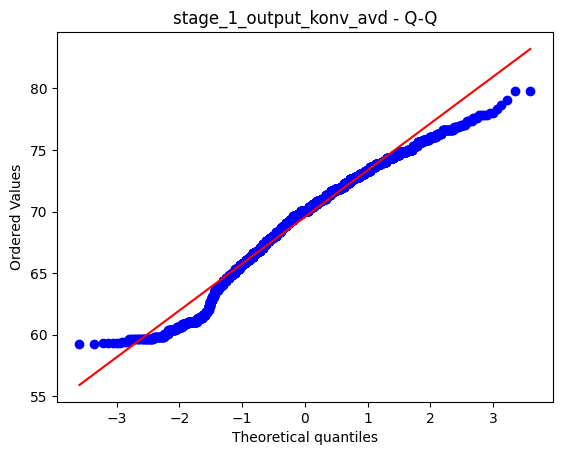

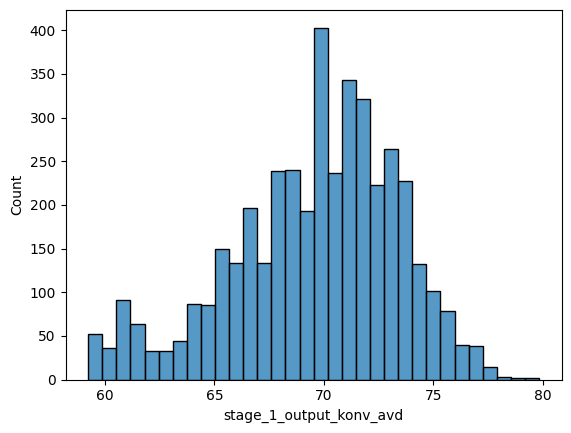

-------------------------------------------------------------------------------
stage_2_input_water_sum


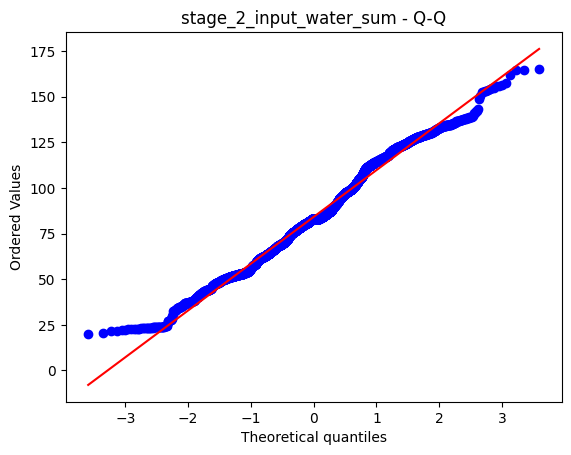

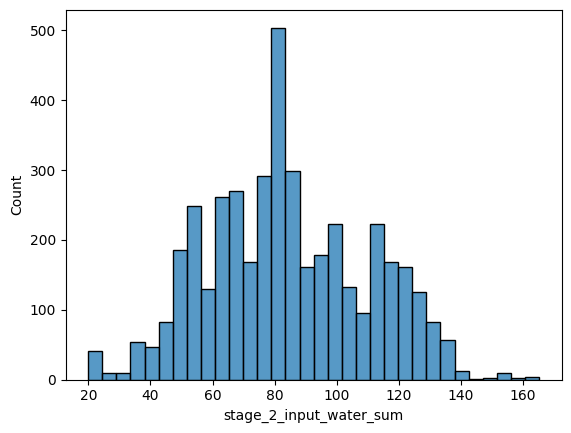

-------------------------------------------------------------------------------
stage_2_output_bottom_pressure


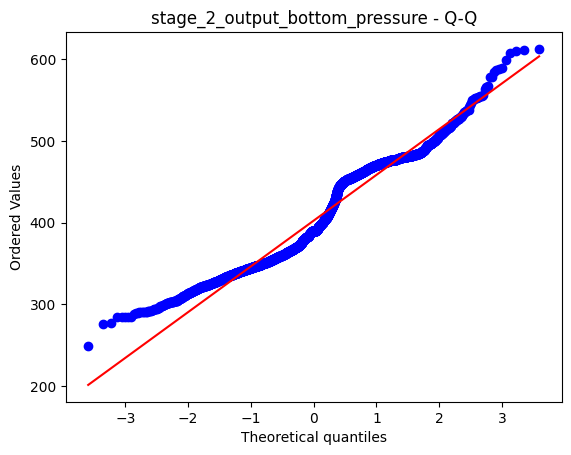

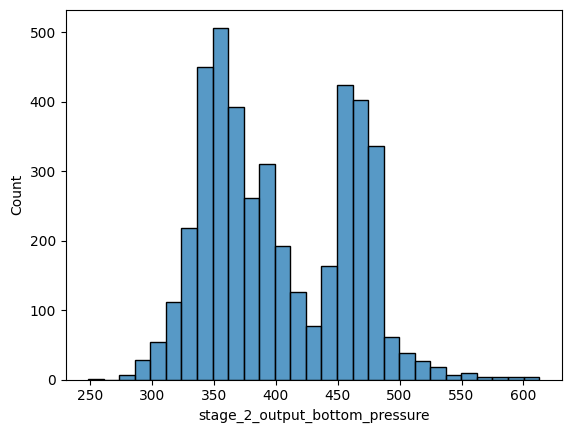

-------------------------------------------------------------------------------
stage_2_output_bottom_temp


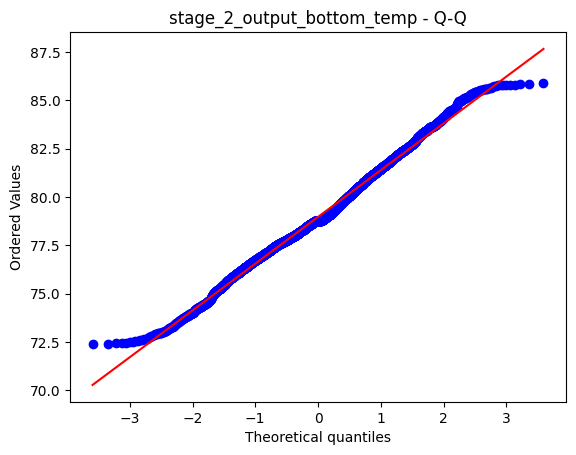

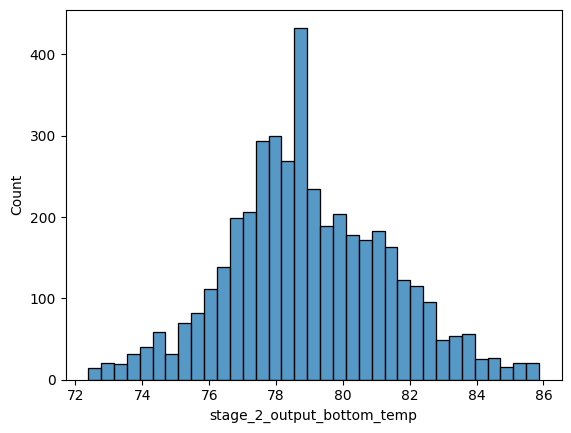

-------------------------------------------------------------------------------
stage_2_output_bottom_temp_hum_steam


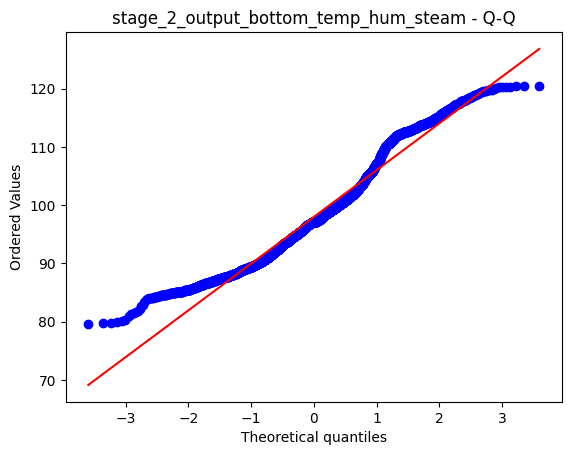

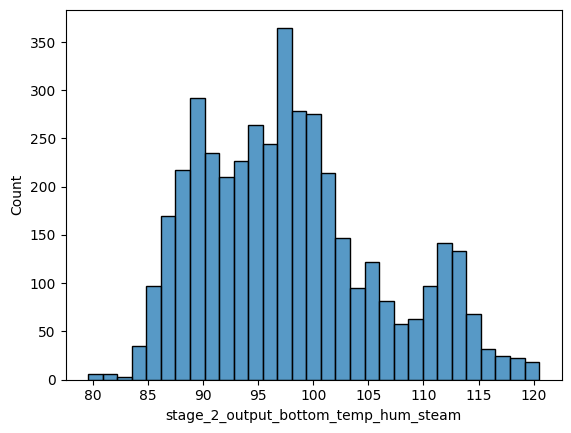

-------------------------------------------------------------------------------
stage_2_output_bottom_vacuum


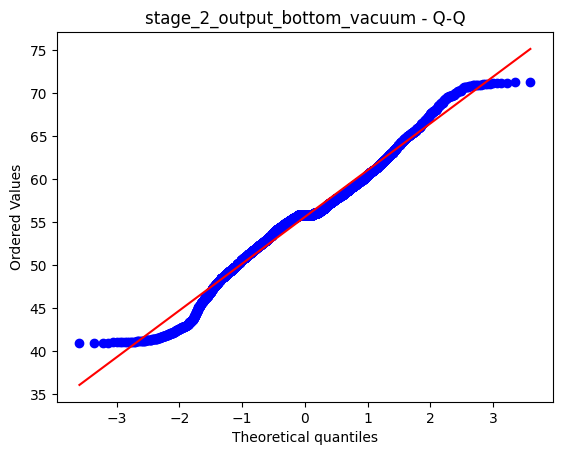

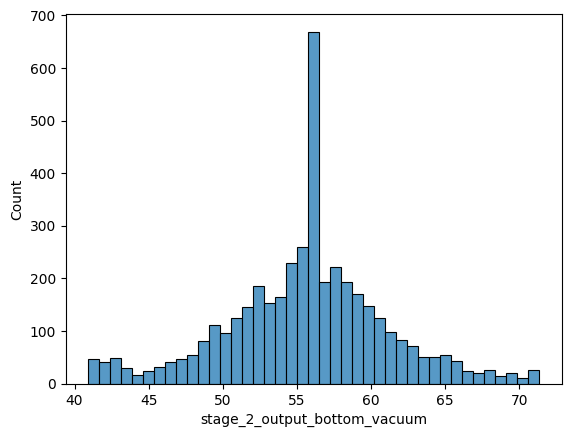

-------------------------------------------------------------------------------
stage_2_output_top_pressure


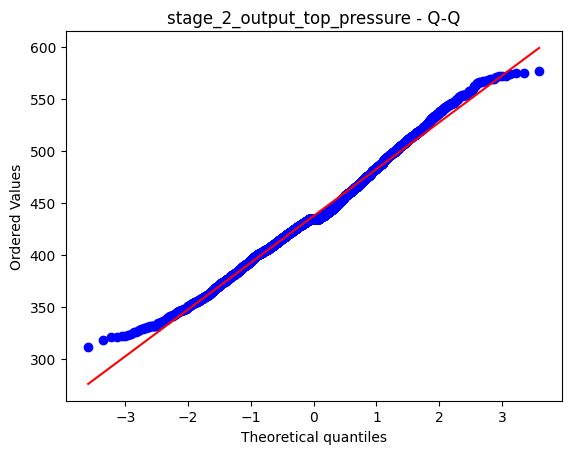

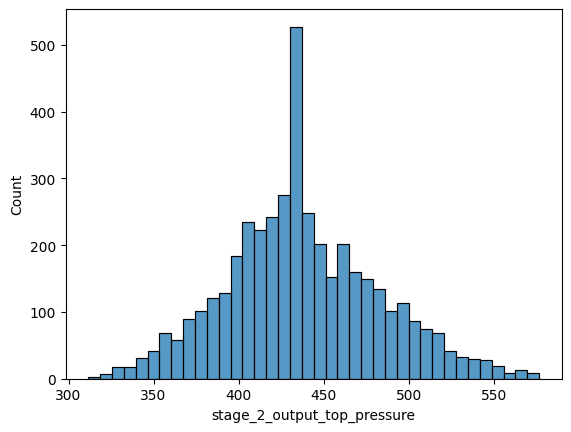

-------------------------------------------------------------------------------
stage_2_output_top_pressure_at_end


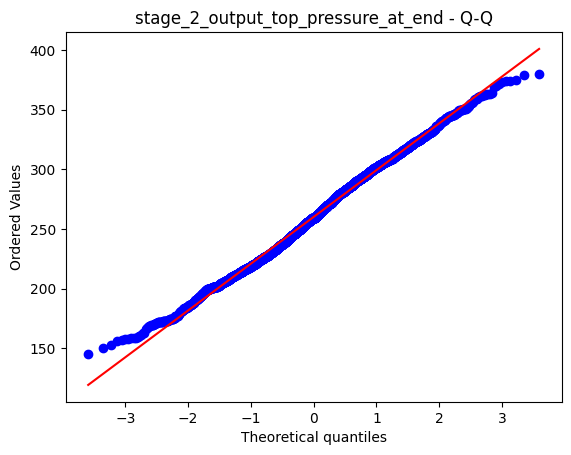

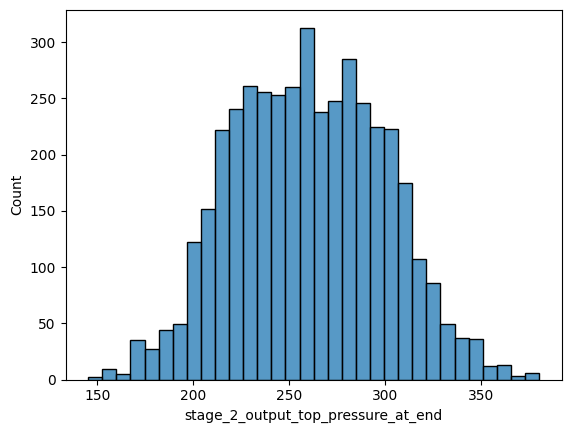

-------------------------------------------------------------------------------
stage_2_output_top_temp


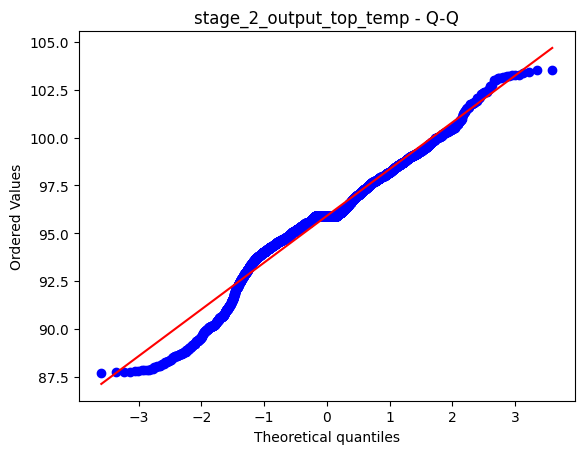

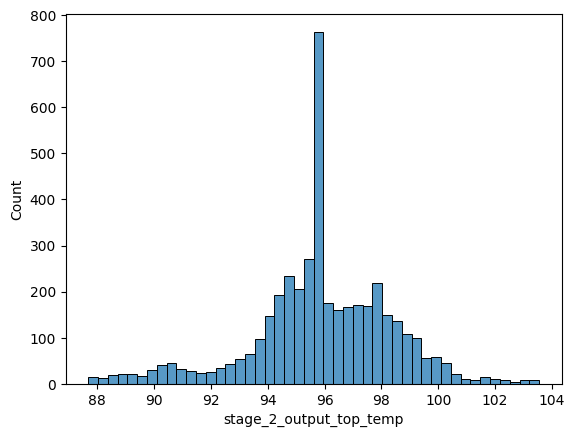

-------------------------------------------------------------------------------
stage_2_output_top_vacuum


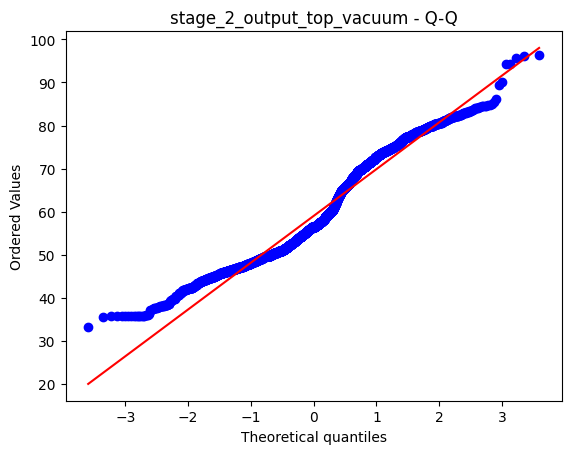

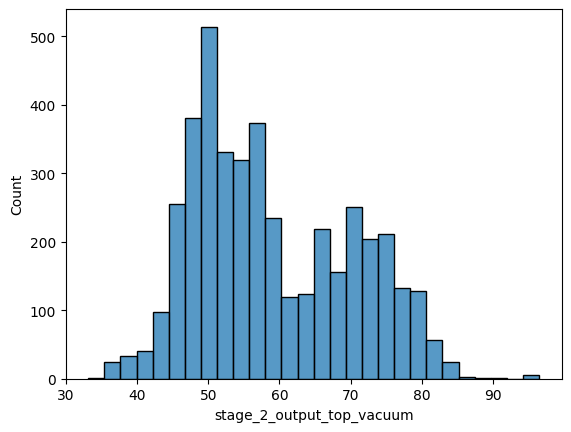

-------------------------------------------------------------------------------
stage_3_input_pressure


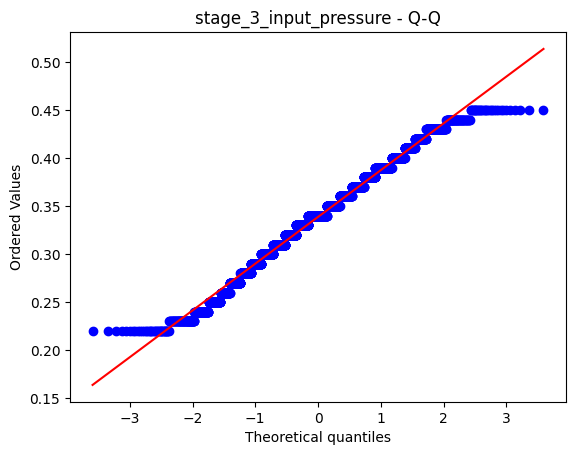

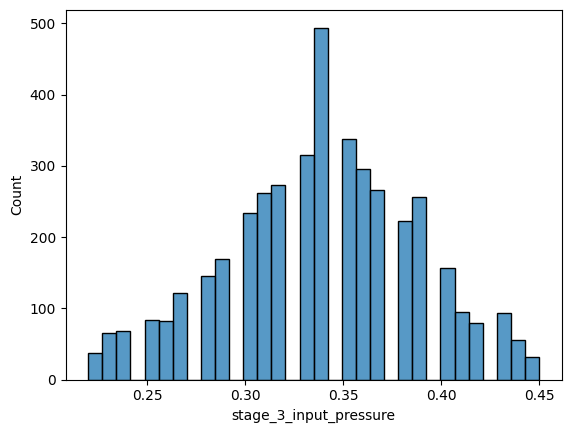

-------------------------------------------------------------------------------
stage_3_input_soft_water


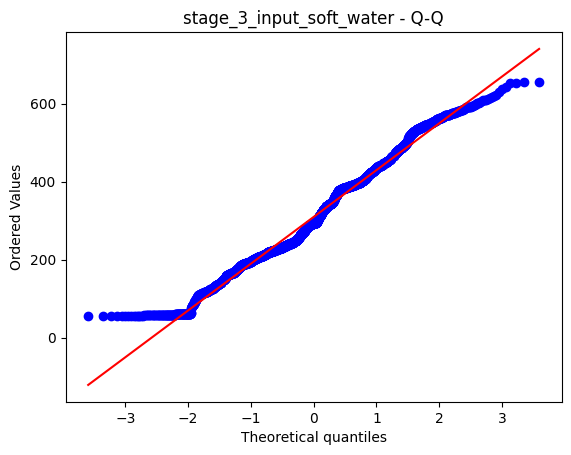

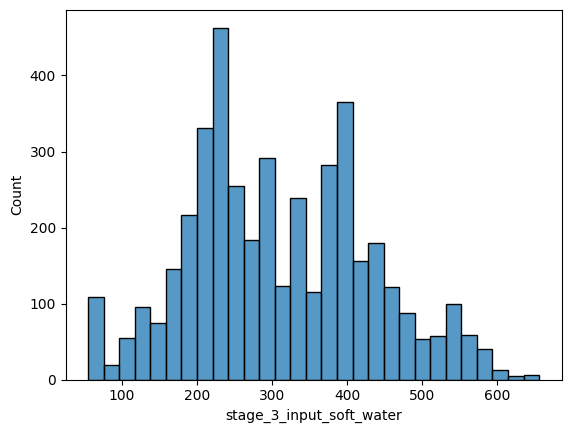

-------------------------------------------------------------------------------
stage_3_input_steam


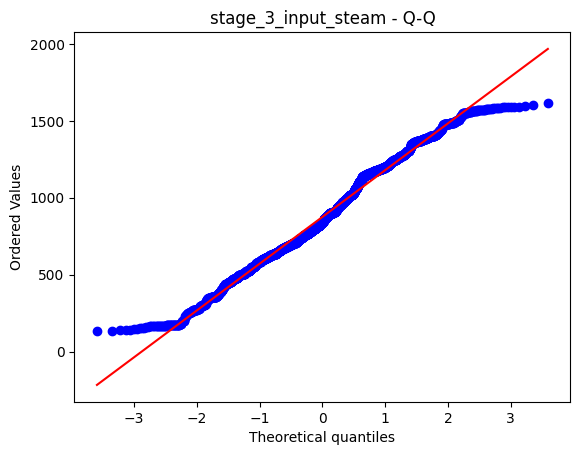

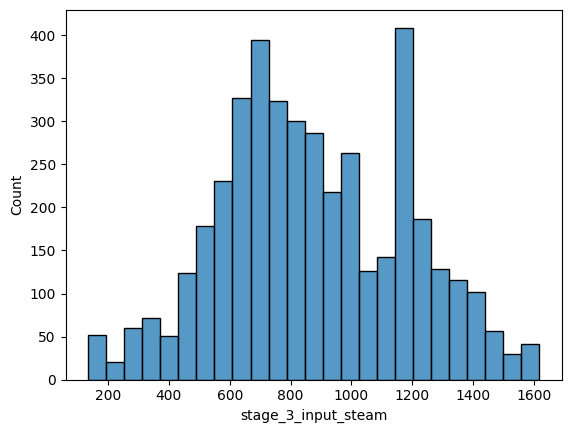

-------------------------------------------------------------------------------
stage_3_output_temp_hum_steam


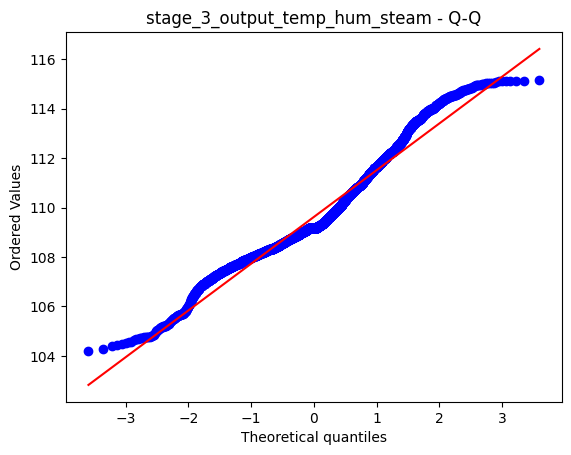

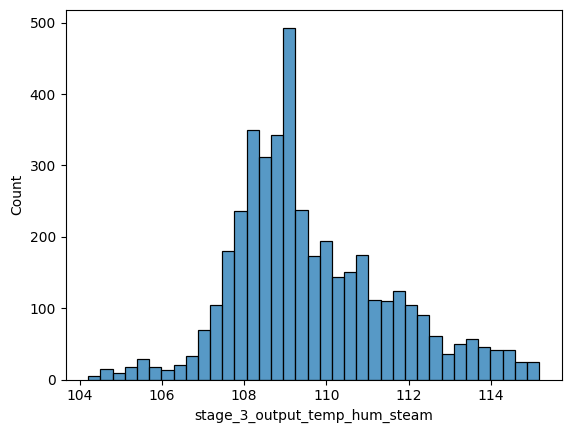

-------------------------------------------------------------------------------
stage_3_output_temp_top


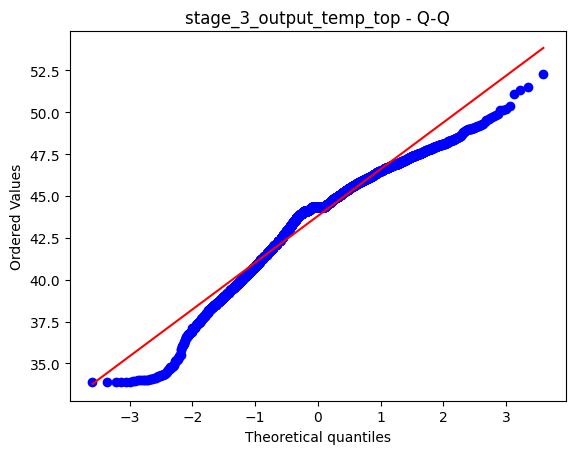

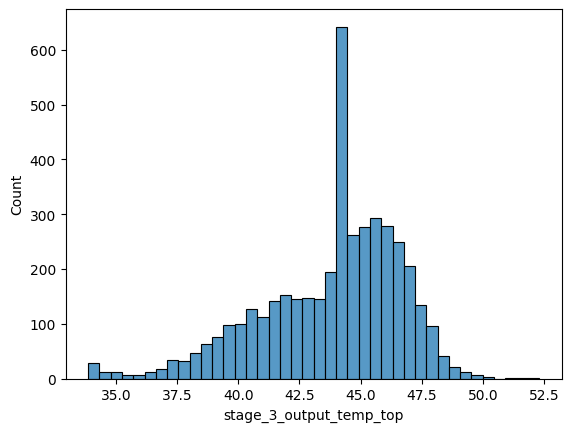

-------------------------------------------------------------------------------
stage_4_input_overheated_steam


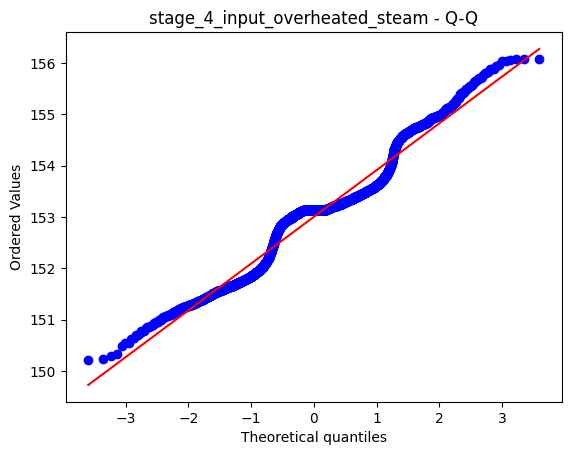

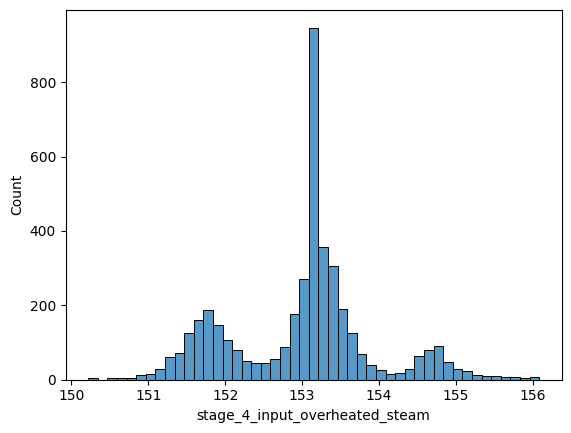

-------------------------------------------------------------------------------
stage_4_input_polymer


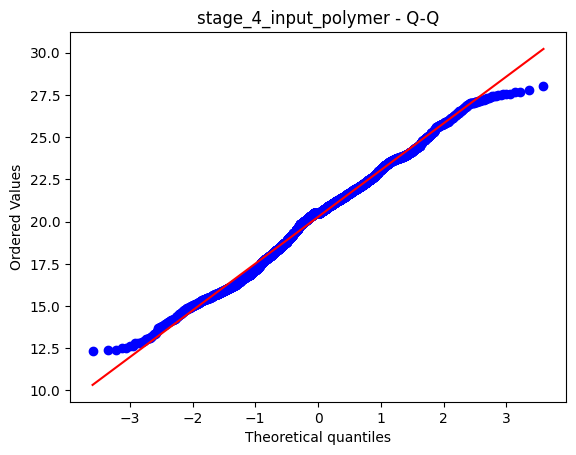

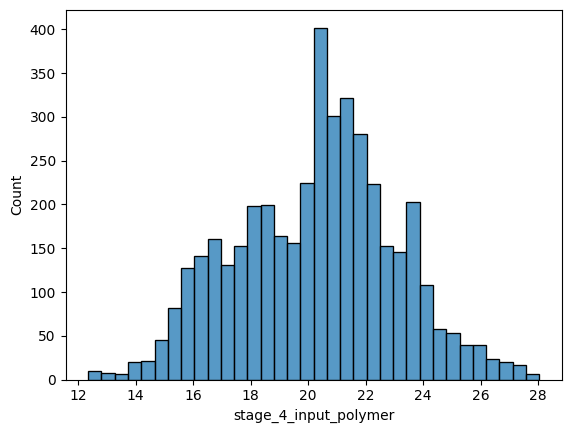

-------------------------------------------------------------------------------
stage_4_input_steam


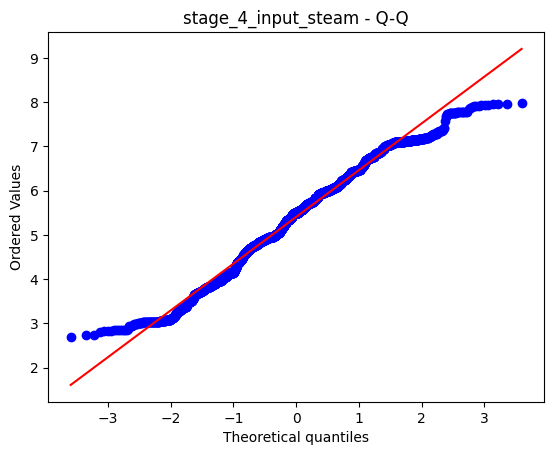

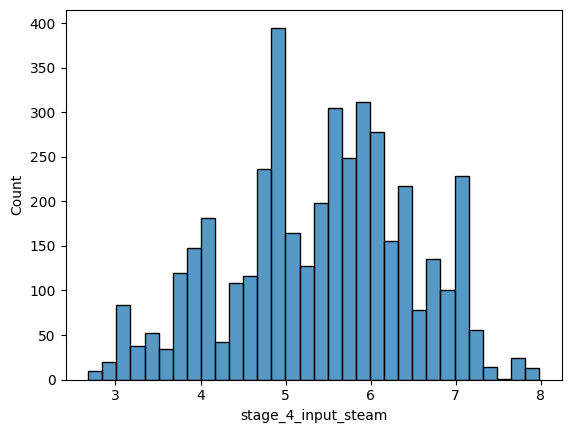

-------------------------------------------------------------------------------
stage_4_input_water


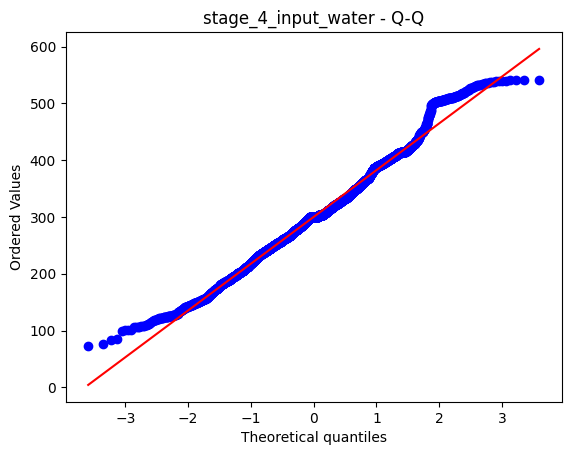

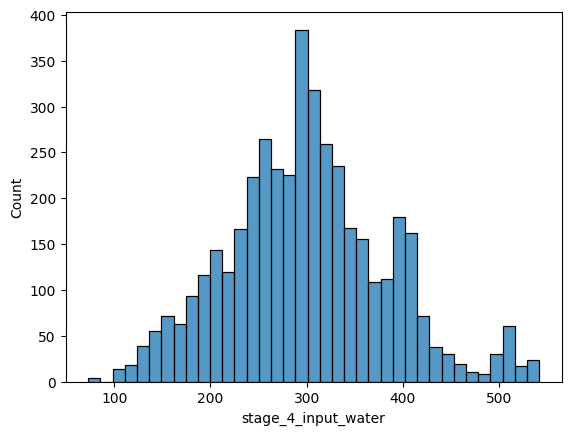

-------------------------------------------------------------------------------
stage_4_output_danger_gas


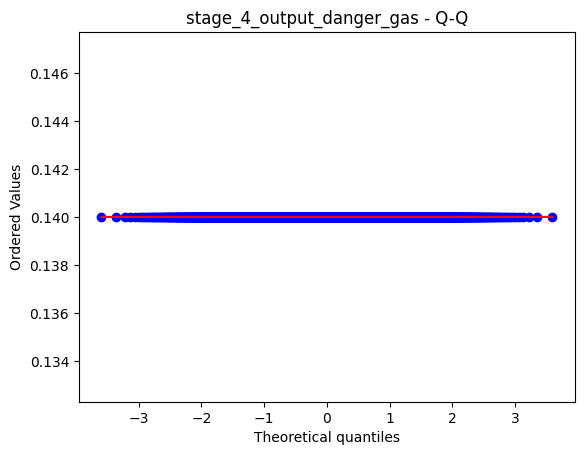

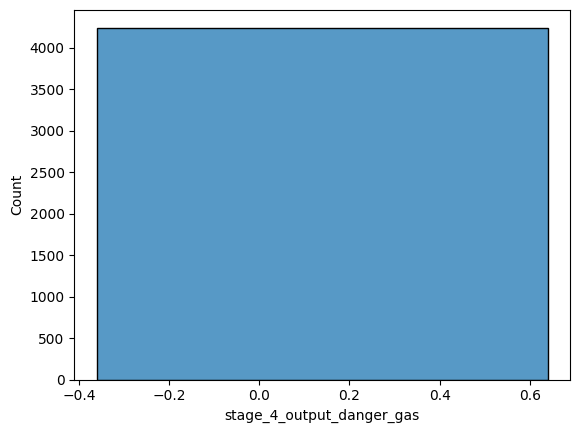

-------------------------------------------------------------------------------
stage_4_output_dry_residue_avg


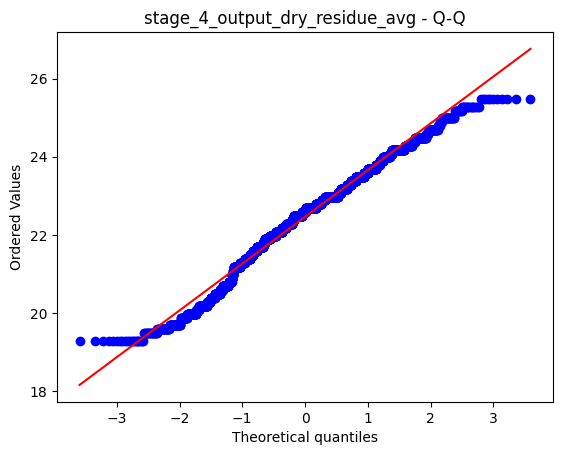

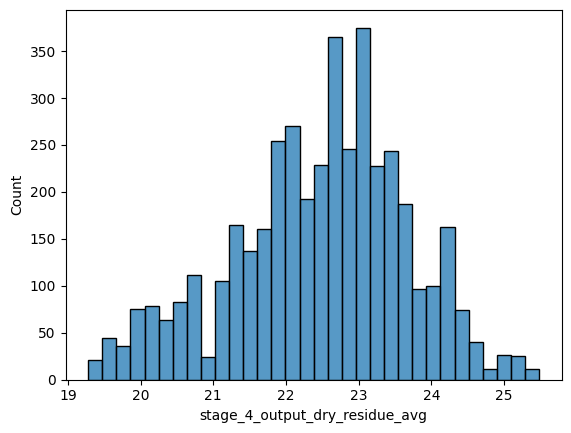

-------------------------------------------------------------------------------
stage_4_output_product


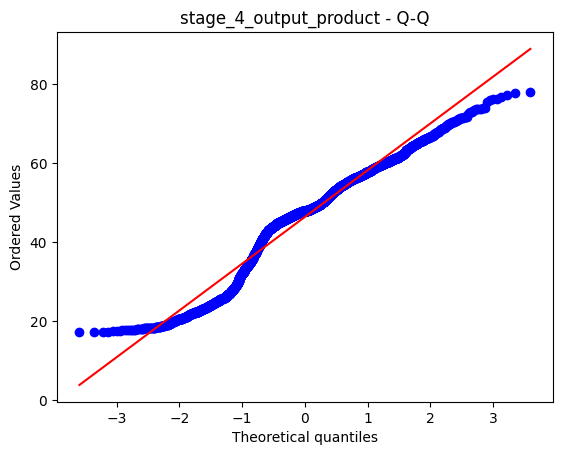

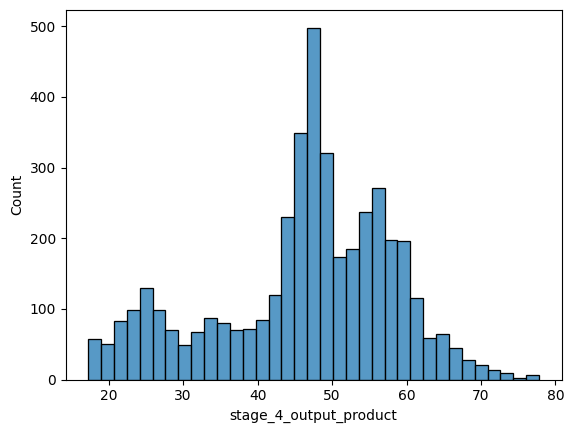

-------------------------------------------------------------------------------
work_shift


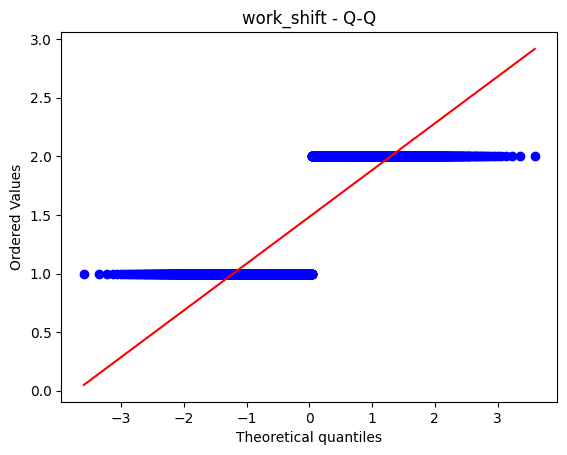

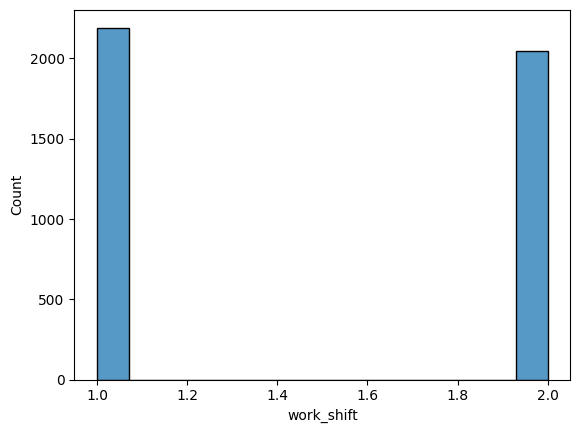

-------------------------------------------------------------------------------


In [ ]:
for i in df2:
  print(i)
  stats.probplot(df2[i], dist="norm", plot=plt)
  plt.title(f"{i} - Q-Q")
  plt.show()
  sns.histplot(df2[i])
  plt.show()
  print("-------------------------------------------------------------------------------")

###########################################################################
Типы Q-Q графиков
Существует несколько типов графиков Q-Q, обычно используемых в статистике и анализе данных, каждый из которых подходит для различных сценариев или целей:

1. Нормальное распределение: симметричное распределение, при котором график Q-Q будет показывать точки примерно вдоль диагональной линии, если данные соответствуют нормальному распределению.
2. Распределение с перекос вправо: Распределение, при котором график Q-Q будет отображать шаблон, при котором наблюдаемые квантили отклоняются от прямой линии к верхнему концу, указывая на более длинный хвост с правой стороны.
3. Распределение с перекос влево: Распределение, при котором график Q-Q будет демонстрировать закономерность, при которой наблюдаемые квантили отклоняются от прямой линии к нижнему концу, указывая на более длинный хвост с левой стороны.
4. Недостаточно распределенное распределение: Распределение, при котором график Q-Q показывает, что наблюдаемые квантили более плотно сгруппированы вокруг диагональной линии по сравнению с теоретическими квантилями, что предполагает меньшую дисперсию.
5. сверхдисперсное распределение: распределение, при котором график Q-Q будет отображать наблюдаемые квантили более разбросанными или отклоняющимися от диагональной линии, что указывает на более высокую дисперсию по сравнению с теоретическим распределением.


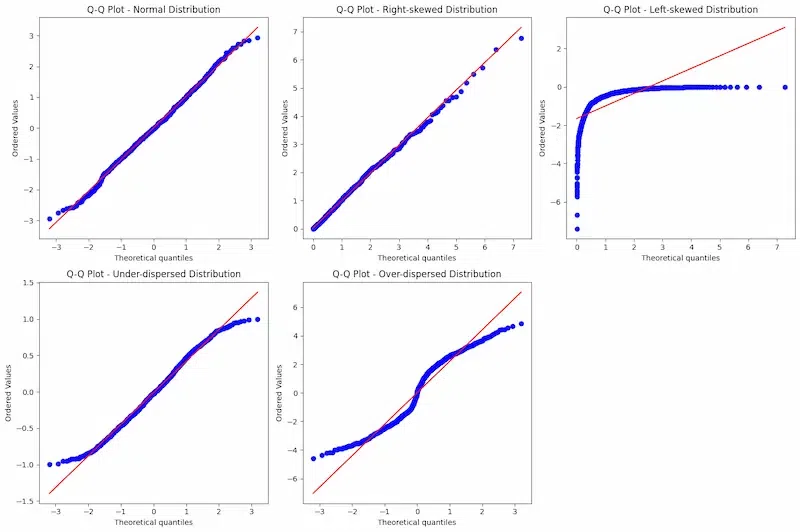

https://www.geeksforgeeks.org/quantile-quantile-plots/